# Playground code for Technical Paper
- These code is rather messy as many fragmented code are everywhere
- The full not-so-messy code will be uploaded to https://github.com/jonidayo ...

In [ ]:
!nvidia-smi -L

GPU 0: GeForce RTX 3090 (UUID: GPU-9c4d80a9-842f-a8bc-61df-0115982fa148)


In [ ]:
!pip install matplotlib
!pip install seaborn
!pip install torch-summary
!pip install -U scikit-learn
!pip install pthflops
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Operation cancelled by user
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from torchvision.models import resnet18
from functools import partial
from pthflops import count_ops
import torch, re, time, gc, itertools, random, os ,sys, random
from IPython.display import clear_output
import torch.optim as optim
import torchvision
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.utils.checkpoint as cp
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torchvision import datasets
from torch import Tensor
import torchvision.transforms as transforms
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd 
from copy import copy, deepcopy
import pandas as pd
from collections import OrderedDict
from typing import Any, Callable, List, Optional, Type, Union, Tuple, Sequence, cast, Dict
from sklearn.metrics import classification_report, confusion_matrix
from torchsummary import summary
from einops import rearrange
from einops.layers.torch import Rearrange
from torchvision.models import mobilenetv3, mnasnet, shufflenetv2, efficientnet
from torchvision.ops.misc import Conv2dNormActivation
from torchvision.ops.misc import Conv2dNormActivation, SqueezeExcitation as SElayer

# Tensorflow for the coarse labelled data only
# from tensorflow.keras.datasets.cifar100 import load_data

# from sklearn.preprocessing import OneHotEncoder

sns.set(style="ticks")

# Device configuration

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My\ Drive/Skool/2022sem2/DELE/CA1_tech

Mounted at /content/drive/
/content/drive/My Drive/Skool/2022sem2/DELE/CA1_tech


In [ ]:
class AlexNet(nn.Module):
    def __init__(self, num_classes: int = 1000, dropout: float = 0.5, inp=3) -> None:
        super().__init__()
        (self)
        self.features = nn.Sequential(
            nn.Conv2d(inp, 32, kernel_size=5, stride=2, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [ ]:

def _make_divisible(v: float, divisor: int, min_value: Optional[int] = None) -> int:
    """
    This function is taken from the original tf repo.
    It ensures that all layers have a channel number that is divisible by 8
    It can be seen here:
    https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet.py
    """
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v

class InvertedResidual(nn.Module):
    def __init__(
        self, inp: int, oup: int, stride: int, expand_ratio: int, norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super().__init__()
        self.stride = stride
        if stride not in [1, 2]:
            raise ValueError(f"stride should be 1 or 2 insted of {stride}")

        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        hidden_dim = int(round(inp * expand_ratio))
        self.use_res_connect = self.stride == 1 and inp == oup

        layers: List[nn.Module] = []
        if expand_ratio != 1:
            # pw
            layers.append(
                Conv2dNormActivation(inp, hidden_dim, kernel_size=1, norm_layer=norm_layer, activation_layer=nn.ReLU6)
            )
        layers.extend(
            [
                # dw
                Conv2dNormActivation(
                    hidden_dim,
                    hidden_dim,
                    stride=stride,
                    groups=hidden_dim,
                    norm_layer=norm_layer,
                    activation_layer=nn.ReLU6,
                ),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                norm_layer(oup),
            ]
        )
        self.conv = nn.Sequential(*layers)
        self.out_channels = oup
        self._is_cn = stride > 1

    def forward(self, x: Tensor) -> Tensor:
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)


class MobileNetV2(nn.Module):
    def __init__(
        self,
        num_classes: int = 10,
        width_mult: float = 1.0,
        inverted_residual_setting: Optional[List[List[int]]] = None,
        round_nearest: int = 8,
        block: Optional[Callable[..., nn.Module]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
        dropout: float = 0.2,
        inp: int = 3
    ) -> None:
        """
        MobileNet V2 main class
        Args:
            num_classes (int): Number of classes
            width_mult (float): Width multiplier - adjusts number of channels in each layer by this amount
            inverted_residual_setting: Network structure
            round_nearest (int): Round the number of channels in each layer to be a multiple of this number
            Set to 1 to turn off rounding
            block: Module specifying inverted residual building block for mobilenet
            norm_layer: Module specifying the normalization layer to use
            dropout (float): The droupout probability
        """
        super().__init__()
        (self)

        if block is None:
            block = InvertedResidual

        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        input_channel = 32
        last_channel = 1280

        if inverted_residual_setting is None:
            inverted_residual_setting = [
                # t, c, n, s
                [1, 16, 1, 1],
                [6, 24, 2, 2],
                [6, 32, 3, 2],
                [6, 64, 4, 2],
                [6, 96, 3, 1],
                [6, 160, 3, 2],
                [6, 320, 1, 1],
            ]

        # only check the first element, assuming user knows t,c,n,s are required
        if len(inverted_residual_setting) == 0 or len(inverted_residual_setting[0]) != 4:
            raise ValueError(
                f"inverted_residual_setting should be non-empty or a 4-element list, got {inverted_residual_setting}"
            )

        # building first layer
        input_channel = _make_divisible(input_channel * width_mult, round_nearest)
        self.last_channel = _make_divisible(last_channel * max(1.0, width_mult), round_nearest)
        features: List[nn.Module] = [
            Conv2dNormActivation(inp, input_channel, stride=2, norm_layer=norm_layer, activation_layer=nn.ReLU6)
        ]
        # building inverted residual blocks
        for t, c, n, s in inverted_residual_setting:
            output_channel = _make_divisible(c * width_mult, round_nearest)
            for i in range(n):
                stride = s if i == 0 else 1
                features.append(block(input_channel, output_channel, stride, expand_ratio=t, norm_layer=norm_layer))
                input_channel = output_channel
        # building last several layers
        features.append(
            Conv2dNormActivation(
                input_channel, self.last_channel, kernel_size=1, norm_layer=norm_layer, activation_layer=nn.ReLU6
            )
        )
        # make it nn.Sequential
        self.features = nn.Sequential(*features)

        # building classifier
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(self.last_channel, num_classes),
        )

        # weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out")
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # This exists since TorchScript doesn't support inheritance, so the superclass method
        # (this one) needs to have a name other than `forward` that can be accessed in a subclass
        x = self.features(x)
        # Cannot use "squeeze" as batch-size can be 1
        x = nn.functional.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)

In [ ]:
class _InvertedResidual(nn.Module):
    def __init__(
        self, in_ch: int, out_ch: int, kernel_size: int, stride: int, expansion_factor: int, bn_momentum: float = 0.1
    ) -> None:
        super().__init__()
        if stride not in [1, 2]:
            raise ValueError(f"stride should be 1 or 2 instead of {stride}")
        if kernel_size not in [3, 5]:
            raise ValueError(f"kernel_size should be 3 or 5 instead of {kernel_size}")
        mid_ch = in_ch * expansion_factor
        self.apply_residual = in_ch == out_ch and stride == 1
        self.layers = nn.Sequential(
            # Pointwise
            nn.Conv2d(in_ch, mid_ch, 1, bias=False),
            nn.BatchNorm2d(mid_ch, momentum=bn_momentum),
            nn.ReLU(inplace=True),
            # Depthwise
            nn.Conv2d(mid_ch, mid_ch, kernel_size, padding=kernel_size // 2, stride=stride, groups=mid_ch, bias=False),
            nn.BatchNorm2d(mid_ch, momentum=bn_momentum),
            nn.ReLU(inplace=True),
            # Linear pointwise. Note that there's no activation.
            nn.Conv2d(mid_ch, out_ch, 1, bias=False),
            nn.BatchNorm2d(out_ch, momentum=bn_momentum),
        )

    def forward(self, input: Tensor) -> Tensor:
        if self.apply_residual:
            return self.layers(input) + input
        else:
            return self.layers(input)


def _stack(
    in_ch: int, out_ch: int, kernel_size: int, stride: int, exp_factor: int, repeats: int, bn_momentum: float
) -> nn.Sequential:
    """Creates a stack of inverted residuals."""
    if repeats < 1:
        raise ValueError(f"repeats should be >= 1, instead got {repeats}")
    # First one has no skip, because feature map size changes.
    first = _InvertedResidual(in_ch, out_ch, kernel_size, stride, exp_factor, bn_momentum=bn_momentum)
    remaining = []
    for _ in range(1, repeats):
        remaining.append(_InvertedResidual(out_ch, out_ch, kernel_size, 1, exp_factor, bn_momentum=bn_momentum))
    return nn.Sequential(first, *remaining)


def _round_to_multiple_of(val: float, divisor: int, round_up_bias: float = 0.9) -> int:
    """Asymmetric rounding to make `val` divisible by `divisor`. With default
    bias, will round up, unless the number is no more than 10% greater than the
    smaller divisible value, i.e. (83, 8) -> 80, but (84, 8) -> 88."""
    if not 0.0 < round_up_bias < 1.0:
        raise ValueError(f"round_up_bias should be greater than 0.0 and smaller than 1.0 instead of {round_up_bias}")
    new_val = max(divisor, int(val + divisor / 2) // divisor * divisor)
    return new_val if new_val >= round_up_bias * val else new_val + divisor


def _get_depths(alpha: float) -> List[int]:
    """Scales tensor depths as in reference MobileNet code, prefers rouding up
    rather than down."""
    depths = [32, 16, 24, 40, 80, 96, 192, 320]
    return [_round_to_multiple_of(depth * alpha, 8) for depth in depths]

_BN_MOMENTUM = 1 - 0.9997

class MNASNet(torch.nn.Module):
    """MNASNet, as described in https://arxiv.org/pdf/1807.11626.pdf. This
    implements the B1 variant of the model.
    >>> model = MNASNet(1.0, num_classes=1000)
    >>> x = torch.rand(1, 3, 224, 224)
    >>> y = model(x)
    >>> y.dim()
    2
    >>> y.nelement()
    1000
    """

    # Version 2 adds depth scaling in the initial stages of the network.
    _version = 2

    def __init__(self, alpha: float, num_classes: int = 10, dropout: float = 0.2, inp = 3) -> None:
        super().__init__()
        (self)
        if alpha <= 0.0:
            raise ValueError(f"alpha should be greater than 0.0 instead of {alpha}")
        self.alpha = alpha
        self.num_classes = num_classes
        depths = _get_depths(alpha)
        layers = [
            # First layer: regular conv.
            nn.Conv2d(inp, depths[0], 3, padding=1, stride=2, bias=False),
            nn.BatchNorm2d(depths[0], momentum=_BN_MOMENTUM),
            nn.ReLU(inplace=True),
            # Depthwise separable, no skip.
            nn.Conv2d(depths[0], depths[0], 3, padding=1, stride=1, groups=depths[0], bias=False),
            nn.BatchNorm2d(depths[0], momentum=_BN_MOMENTUM),
            nn.ReLU(inplace=True),
            nn.Conv2d(depths[0], depths[1], 1, padding=0, stride=1, bias=False),
            nn.BatchNorm2d(depths[1], momentum=_BN_MOMENTUM),
            # MNASNet blocks: stacks of inverted residuals.
            _stack(depths[1], depths[2], 3, 2, 3, 3, _BN_MOMENTUM),
            _stack(depths[2], depths[3], 5, 2, 3, 3, _BN_MOMENTUM),
            _stack(depths[3], depths[4], 5, 2, 6, 3, _BN_MOMENTUM),
            _stack(depths[4], depths[5], 3, 1, 6, 2, _BN_MOMENTUM),
            _stack(depths[5], depths[6], 5, 2, 6, 4, _BN_MOMENTUM),
            _stack(depths[6], depths[7], 3, 1, 6, 1, _BN_MOMENTUM),
            # Final mapping to classifier input.
            nn.Conv2d(depths[7], 1280, 1, padding=0, stride=1, bias=False),
            nn.BatchNorm2d(1280, momentum=_BN_MOMENTUM),
            nn.ReLU(inplace=True),
        ]
        self.layers = nn.Sequential(*layers)
        self.classifier = nn.Sequential(nn.Dropout(p=dropout, inplace=True), nn.Linear(1280, num_classes))

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, mode="fan_out", nonlinearity="sigmoid")
                nn.init.zeros_(m.bias)

    def forward(self, x: Tensor) -> Tensor:
        x = self.layers(x)
        # Equivalent to global avgpool and removing H and W dimensions.
        x = x.mean([2, 3])
        return self.classifier(x)

In [ ]:
class InvertedResidualConfig:
    # Stores information listed at Tables 1 and 2 of the MobileNetV3 paper
    def __init__(
        self,
        input_channels: int,
        kernel: int,
        expanded_channels: int,
        out_channels: int,
        use_se: bool,
        activation: str,
        stride: int,
        dilation: int,
        width_mult: float,
    ):
        self.input_channels = self.adjust_channels(input_channels, width_mult)
        self.kernel = kernel
        self.expanded_channels = self.adjust_channels(expanded_channels, width_mult)
        self.out_channels = self.adjust_channels(out_channels, width_mult)
        self.use_se = use_se
        self.use_hs = activation == "HS"
        self.stride = stride
        self.dilation = dilation

    @staticmethod
    def adjust_channels(channels: int, width_mult: float):
        return _make_divisible(channels * width_mult, 8)


class InvertedResidual(nn.Module):
    # Implemented as described at section 5 of MobileNetV3 paper
    def __init__(
        self,
        cnf: InvertedResidualConfig,
        norm_layer: Callable[..., nn.Module],
        se_layer: Callable[..., nn.Module] = partial(SElayer, scale_activation=nn.Hardsigmoid),
    ):
        super().__init__()
        if not (1 <= cnf.stride <= 2):
            raise ValueError("illegal stride value")

        self.use_res_connect = cnf.stride == 1 and cnf.input_channels == cnf.out_channels

        layers: List[nn.Module] = []
        activation_layer = nn.Hardswish if cnf.use_hs else nn.ReLU

        # expand
        if cnf.expanded_channels != cnf.input_channels:
            layers.append(
                Conv2dNormActivation(
                    cnf.input_channels,
                    cnf.expanded_channels,
                    kernel_size=1,
                    norm_layer=norm_layer,
                    activation_layer=activation_layer,
                )
            )

        # depthwise
        stride = 1 if cnf.dilation > 1 else cnf.stride
        layers.append(
            Conv2dNormActivation(
                cnf.expanded_channels,
                cnf.expanded_channels,
                kernel_size=cnf.kernel,
                stride=stride,
                dilation=cnf.dilation,
                groups=cnf.expanded_channels,
                norm_layer=norm_layer,
                activation_layer=activation_layer,
            )
        )
        if cnf.use_se:
            squeeze_channels = _make_divisible(cnf.expanded_channels // 4, 8)
            layers.append(se_layer(cnf.expanded_channels, squeeze_channels))

        # project
        layers.append(
            Conv2dNormActivation(
                cnf.expanded_channels, cnf.out_channels, kernel_size=1, norm_layer=norm_layer, activation_layer=None
            )
        )

        self.block = nn.Sequential(*layers)
        self.out_channels = cnf.out_channels
        self._is_cn = cnf.stride > 1

    def forward(self, input: Tensor) -> Tensor:
        result = self.block(input)
        if self.use_res_connect:
            result += input
        return result


class MobileNetV3(nn.Module):
    def __init__(
        self,
        inverted_residual_setting: List[InvertedResidualConfig],
        last_channel: int,
        num_classes: int = 10,
        block: Optional[Callable[..., nn.Module]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
        dropout: float = 0.2,
        inp:int = 3,
        **kwargs: Any,
    ) -> None:
        """
        MobileNet V3 main class
        Args:
            inverted_residual_setting (List[InvertedResidualConfig]): Network structure
            last_channel (int): The number of channels on the penultimate layer
            num_classes (int): Number of classes
            block (Optional[Callable[..., nn.Module]]): Module specifying inverted residual building block for mobilenet
            norm_layer (Optional[Callable[..., nn.Module]]): Module specifying the normalization layer to use
            dropout (float): The droupout probability
        """
        super().__init__()

        if not inverted_residual_setting:
            raise ValueError("The inverted_residual_setting should not be empty")
        elif not (
            isinstance(inverted_residual_setting, Sequence)
            and all([isinstance(s, InvertedResidualConfig) for s in inverted_residual_setting])
        ):
            raise TypeError("The inverted_residual_setting should be List[InvertedResidualConfig]")

        if block is None:
            block = InvertedResidual

        if norm_layer is None:
            norm_layer = partial(nn.BatchNorm2d, eps=0.001, momentum=0.01)

        layers: List[nn.Module] = []

        # building first layer
        firstconv_output_channels = inverted_residual_setting[0].input_channels
        layers.append(
            Conv2dNormActivation(
                inp,
                firstconv_output_channels,
                kernel_size=3,
                stride=2,
                norm_layer=norm_layer,
                activation_layer=nn.Hardswish,
            )
        )

        # building inverted residual blocks
        for cnf in inverted_residual_setting:
            layers.append(block(cnf, norm_layer))

        # building last several layers
        lastconv_input_channels = inverted_residual_setting[-1].out_channels
        lastconv_output_channels = 6 * lastconv_input_channels
        layers.append(
            Conv2dNormActivation(
                lastconv_input_channels,
                lastconv_output_channels,
                kernel_size=1,
                norm_layer=norm_layer,
                activation_layer=nn.Hardswish,
            )
        )

        self.features = nn.Sequential(*layers)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Linear(lastconv_output_channels, last_channel),
            nn.Hardswish(inplace=True),
            nn.Dropout(p=dropout, inplace=True),
            nn.Linear(last_channel, num_classes),
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out")
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)

    def _forward_impl(self, x: Tensor) -> Tensor:
        x = self.features(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)

        x = self.classifier(x)

        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)

def _mobilenet_v3_conf(
    arch: str, width_mult: float = 1.0, reduced_tail: bool = False, dilated: bool = False, **kwargs: Any
):
    reduce_divider = 2 if reduced_tail else 1
    dilation = 2 if dilated else 1

    bneck_conf = partial(InvertedResidualConfig, width_mult=width_mult)
    adjust_channels = partial(InvertedResidualConfig.adjust_channels, width_mult=width_mult)

    if arch == "mobilenet_v3_large":
        inverted_residual_setting = [
            bneck_conf(16, 3, 16, 16, False, "RE", 1, 1),
            bneck_conf(16, 3, 64, 24, False, "RE", 2, 1),  # C1
            bneck_conf(24, 3, 72, 24, False, "RE", 1, 1),
            bneck_conf(24, 5, 72, 40, True, "RE", 2, 1),  # C2
            bneck_conf(40, 5, 120, 40, True, "RE", 1, 1),
            bneck_conf(40, 5, 120, 40, True, "RE", 1, 1),
            bneck_conf(40, 3, 240, 80, False, "HS", 2, 1),  # C3
            bneck_conf(80, 3, 200, 80, False, "HS", 1, 1),
            bneck_conf(80, 3, 184, 80, False, "HS", 1, 1),
            bneck_conf(80, 3, 184, 80, False, "HS", 1, 1),
            bneck_conf(80, 3, 480, 112, True, "HS", 1, 1),
            bneck_conf(112, 3, 672, 112, True, "HS", 1, 1),
            bneck_conf(112, 5, 672, 160 // reduce_divider, True, "HS", 2, dilation),  # C4
            bneck_conf(160 // reduce_divider, 5, 960 // reduce_divider, 160 // reduce_divider, True, "HS", 1, dilation),
            bneck_conf(160 // reduce_divider, 5, 960 // reduce_divider, 160 // reduce_divider, True, "HS", 1, dilation),
        ]
        last_channel = adjust_channels(1280 // reduce_divider)  # C5
    elif arch == "mobilenet_v3_small":
        inverted_residual_setting = [
            bneck_conf(16, 3, 16, 16, True, "RE", 2, 1),  # C1
            bneck_conf(16, 3, 72, 24, False, "RE", 2, 1),  # C2
            bneck_conf(24, 3, 88, 24, False, "RE", 1, 1),
            bneck_conf(24, 5, 96, 40, True, "HS", 2, 1),  # C3
            bneck_conf(40, 5, 240, 40, True, "HS", 1, 1),
            bneck_conf(40, 5, 240, 40, True, "HS", 1, 1),
            bneck_conf(40, 5, 120, 48, True, "HS", 1, 1),
            bneck_conf(48, 5, 144, 48, True, "HS", 1, 1),
            bneck_conf(48, 5, 288, 96 // reduce_divider, True, "HS", 2, dilation),  # C4
            bneck_conf(96 // reduce_divider, 5, 576 // reduce_divider, 96 // reduce_divider, True, "HS", 1, dilation),
            bneck_conf(96 // reduce_divider, 5, 576 // reduce_divider, 96 // reduce_divider, True, "HS", 1, dilation),
        ]
        last_channel = adjust_channels(1024 // reduce_divider)  # C5
    else:
        raise ValueError(f"Unsupported model type {arch}")

    return inverted_residual_setting, last_channel


In [ ]:
def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError("BasicBlock only supports groups=1 and base_width=64")
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        layers: List[int],
        num_classes: int = 10,
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        replace_stride_with_dilation: Optional[List[bool]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
        inp: int = 3
    ) -> None:
        super().__init__()
        (self)
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError(
                "replace_stride_with_dilation should be None "
                f"or a 3-element tuple, got {replace_stride_with_dilation}"
            )
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(inp, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck) and m.bn3.weight is not None:
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock) and m.bn2.weight is not None:
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        planes: int,
        blocks: int,
        stride: int = 1,
        dilate: bool = False,
    ) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes, planes, stride, downsample, self.groups, self.base_width, previous_dilation, norm_layer
            )
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer,
                )
            )

        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)


In [ ]:
class Fire(nn.Module):
    def __init__(self, inplanes: int, squeeze_planes: int, expand1x1_planes: int, expand3x3_planes: int) -> None:
        super().__init__()
        self.inplanes = inplanes
        self.squeeze = nn.Conv2d(inplanes, squeeze_planes, kernel_size=1)
        self.squeeze_activation = nn.ReLU(inplace=True)
        self.expand1x1 = nn.Conv2d(squeeze_planes, expand1x1_planes, kernel_size=1)
        self.expand1x1_activation = nn.ReLU(inplace=True)
        self.expand3x3 = nn.Conv2d(squeeze_planes, expand3x3_planes, kernel_size=3, padding=1)
        self.expand3x3_activation = nn.ReLU(inplace=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.squeeze_activation(self.squeeze(x))
        return torch.cat(
            [self.expand1x1_activation(self.expand1x1(x)), self.expand3x3_activation(self.expand3x3(x))], 1
        )


class SqueezeNet(nn.Module):
    def __init__(self, version: str = "1_0", num_classes: int = 100, dropout: float = 0.5,inp=3) -> None:
        super().__init__()
        (self)
        self.num_classes = num_classes
        if version == "1_0":
            self.features = nn.Sequential(
                nn.Conv2d(3, 96, kernel_size=7, stride=2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(96, 16, 64, 64),
                Fire(128, 16, 64, 64),
                Fire(128, 32, 128, 128),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(256, 32, 128, 128),
                Fire(256, 48, 192, 192),
                Fire(384, 48, 192, 192),
                Fire(384, 64, 256, 256),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(512, 64, 256, 256),
            )
        elif version == "1_1":
            self.features = nn.Sequential(
                nn.Conv2d(inp, 64, kernel_size=3, stride=2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(64, 16, 64, 64),
                Fire(128, 16, 64, 64),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(128, 32, 128, 128),
                Fire(256, 32, 128, 128),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(256, 48, 192, 192),
                Fire(384, 48, 192, 192),
                Fire(384, 64, 256, 256),
                Fire(512, 64, 256, 256),
            )
        else:
            # FIXME: Is this needed? SqueezeNet should only be called from the
            # FIXME: squeezenet1_x() functions
            # FIXME: This checking is not done for the other models
            raise ValueError(f"Unsupported SqueezeNet version {version}: 1_0 or 1_1 expected")

        # Final convolution is initialized differently from the rest
        final_conv = nn.Conv2d(512, self.num_classes, kernel_size=1)
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout), final_conv, nn.ReLU(inplace=True), nn.AdaptiveAvgPool2d((1, 1))
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                if m is final_conv:
                    init.normal_(m.weight, mean=0.0, std=0.01)
                else:
                    init.kaiming_uniform_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.classifier(x)
        return torch.flatten(x, 1)

In [ ]:
def channel_shuffle(x: Tensor, groups: int) -> Tensor:
    batchsize, num_channels, height, width = x.size()
    channels_per_group = num_channels // groups

    # reshape
    x = x.view(batchsize, groups, channels_per_group, height, width)

    x = torch.transpose(x, 1, 2).contiguous()

    # flatten
    x = x.view(batchsize, -1, height, width)

    return x


class InvertedResidual(nn.Module):
    def __init__(self, inp: int, oup: int, stride: int) -> None:
        super().__init__()

        if not (1 <= stride <= 3):
            raise ValueError("illegal stride value")
        self.stride = stride

        branch_features = oup // 2
        if (self.stride == 1) and (inp != branch_features << 1):
            raise ValueError(
                f"Invalid combination of stride {stride}, inp {inp} and oup {oup} values. If stride == 1 then inp should be equal to oup // 2 << 1."
            )

        if self.stride > 1:
            self.branch1 = nn.Sequential(
                self.depthwise_conv(inp, inp, kernel_size=3, stride=self.stride, padding=1),
                nn.BatchNorm2d(inp),
                nn.Conv2d(inp, branch_features, kernel_size=1, stride=1, padding=0, bias=False),
                nn.BatchNorm2d(branch_features),
                nn.ReLU(inplace=True),
            )
        else:
            self.branch1 = nn.Sequential()

        self.branch2 = nn.Sequential(
            nn.Conv2d(
                inp if (self.stride > 1) else branch_features,
                branch_features,
                kernel_size=1,
                stride=1,
                padding=0,
                bias=False,
            ),
            nn.BatchNorm2d(branch_features),
            nn.ReLU(inplace=True),
            self.depthwise_conv(branch_features, branch_features, kernel_size=3, stride=self.stride, padding=1),
            nn.BatchNorm2d(branch_features),
            nn.Conv2d(branch_features, branch_features, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(branch_features),
            nn.ReLU(inplace=True),
        )

    @staticmethod
    def depthwise_conv(
        i: int, o: int, kernel_size: int, stride: int = 1, padding: int = 0, bias: bool = False
    ) -> nn.Conv2d:
        return nn.Conv2d(i, o, kernel_size, stride, padding, bias=bias, groups=i)

    def forward(self, x: Tensor) -> Tensor:
        if self.stride == 1:
            x1, x2 = x.chunk(2, dim=1)
            out = torch.cat((x1, self.branch2(x2)), dim=1)
        else:
            out = torch.cat((self.branch1(x), self.branch2(x)), dim=1)

        out = channel_shuffle(out, 2)

        return out


class ShuffleNetV2(nn.Module):
    def __init__(
        self,
        stages_repeats: List[int],
        stages_out_channels: List[int],
        num_classes: int = 1000,
        inverted_residual: Callable[..., nn.Module] = InvertedResidual,
        inp = 3,
    ) -> None:
        super().__init__()

        if len(stages_repeats) != 3:
            raise ValueError("expected stages_repeats as list of 3 positive ints")
        if len(stages_out_channels) != 5:
            raise ValueError("expected stages_out_channels as list of 5 positive ints")
        self._stage_out_channels = stages_out_channels

        input_channels = inp
        output_channels = self._stage_out_channels[0]
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_channels, output_channels, 3, 2, 1, bias=False),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(inplace=True),
        )
        input_channels = output_channels

        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Static annotations for mypy
        self.stage2: nn.Sequential
        self.stage3: nn.Sequential
        self.stage4: nn.Sequential
        stage_names = [f"stage{i}" for i in [2, 3, 4]]
        for name, repeats, output_channels in zip(stage_names, stages_repeats, self._stage_out_channels[1:]):
            seq = [inverted_residual(input_channels, output_channels, 2)]
            for i in range(repeats - 1):
                seq.append(inverted_residual(output_channels, output_channels, 1))
            setattr(self, name, nn.Sequential(*seq))
            input_channels = output_channels

        output_channels = self._stage_out_channels[-1]
        self.conv5 = nn.Sequential(
            nn.Conv2d(input_channels, output_channels, 1, 1, 0, bias=False),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(inplace=True),
        )

        self.fc = nn.Linear(output_channels, num_classes)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.conv5(x)
        x = x.mean([2, 3])  # globalpool
        x = self.fc(x)
        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)

def _shufflenetv2(
    weights,
    progress: bool,
    *args: Any,
    **kwargs: Any,
) -> ShuffleNetV2:
    if weights is not None:
        pass
        # _ovewrite_named_param(kwargs, "num_classes", len(weights.meta["categories"]))

    model = ShuffleNetV2(*args, **kwargs)

    if weights is not None:
        model.load_state_dict(weights.get_state_dict(progress=progress))

    return model

In [ ]:
class VGG(nn.Module):
    def __init__(
        self, features: nn.Module, num_classes: int = 196, init_weights: bool = True, dropout: float = 0.2
    ) -> None:
        super().__init__()
        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(6272, 512),
            nn.ReLU(True),
            nn.Dropout(p=dropout),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Dropout(p=dropout),
            nn.Linear(512, num_classes),
        )
        if init_weights:
            for m in self.modules():
                if isinstance(m, nn.Conv2d):
                    nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
                    if m.bias is not None:
                        nn.init.constant_(m.bias, 0)
                elif isinstance(m, nn.BatchNorm2d):
                    nn.init.constant_(m.weight, 1)
                    nn.init.constant_(m.bias, 0)
                elif isinstance(m, nn.Linear):
                    nn.init.normal_(m.weight, 0, 0.01)
                    nn.init.constant_(m.bias, 0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


def make_layers(cfg: List[Union[str, int]], batch_norm: bool = False,inp=3) -> nn.Sequential:
    layers: List[nn.Module] = []
    in_channels = inp
    for v in cfg:
        if v == "M":
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            v = cast(int, v)
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


cfgs: Dict[str, List[Union[str, int]]] = {
    "S": [32, "M", 64,64, "M", 128, 128, "M"],
    "A": [64, "M", 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"],
    "B": [64, 64, "M", 128, 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"],
    "D": [64, 64, "M", 128, 128, "M", 256, 256, 256, "M", 512, 512, 512, "M", 512, 512, 512, "M"],
    "E": [64, 64, "M", 128, 128, "M", 256, 256, 256, 256, "M", 512, 512, 512, 512, "M", 512, 512, 512, 512, "M"],

}

def _vgg(cfg: str, batch_norm: bool, **kwargs: Any) -> VGG:
    model = VGG(make_layers(cfgs[cfg], batch_norm=batch_norm,inp=1), **kwargs)
    return model


In [ ]:
# inp = torch.rand(32,1,28,28).to(device)

# resnet_18_custom = ResNet(Bottleneck, [1, 2, 2, 2], num_classes=10,inp=3).to(device)
# mobilenetv2_custom = MobileNetV2(num_classes=49,inp=1).to(device)

# inverted_residual_setting, last_channel = _mobilenet_v3_conf("mobilenet_v3_small")
# inverted_residual_setting2, last_channel2 = _mobilenet_v3_conf("mobilenet_v3_large")
# mobilenetv3_small = MobileNetV3(inverted_residual_setting, last_channel,inp=1).to(device)
# mobilenetv3_large = MobileNetV3(inverted_residual_setting2, last_channel2,inp=1).to(device)
mnasnet_small = MNASNet(0.5,inp=1,num_classes=49).to(device)
# mnasnet_med = MNASNet(1,inp=3).to(device)
# vgg5_small = VGG(make_layers(cfgs['S'], batch_norm=False,inp=1)).to(device)
# shufflenetv2_s = ShuffleNetV2([4,8,4],[24, 48, 96, 192, 1024],inp=3).to(device)
# efficientnet_small = efficientnet.efficientnet_b0(weights=None).to(device)

# squeezenet_M = SqueezeNet("1_1",num_classes=196,inp=1).to(device)

# display(shufflenetv2_s)
# print(count_ops(resnet_18_custom, inp))
# summary(resnet_18_custom,(3,32,32))

# print(count_ops(mobilenetv2_custom, inp))
# summary(mobilenetv2_custom,(3,32,32))


# print(count_ops(mobilenetv3_small, inp))
# summary(mobilenetv3_small,(1,28,28))

# print(count_ops(mobilenetv3_large, inp))
# summary(mobilenetv3_large,(1,28,28))

# print(count_ops(mnasnet_small, inp))
# summary(mnasnet_small,(3,32,32))

# print(count_ops(mnasnet_med, inp))
# summary(mnasnet_med,(3,32,32))

# print(count_ops(vgg9_small, inp))
# summary(vgg9_small,(3,32,32))

# summary(shufflenetv2_s,(3,224,224))
# print(count_ops(shufflenetv2_s, inp))

# print(count_ops(vgg5_small, inp))
# summary(vgg5_small,(1,28,28))

# print(count_ops(efficientnet_small, inp))
# summary(efficientnet_small,(3,224,224))

# print(count_ops(squeezenet_M, inp))
# summary(squeezenet_M,(3,224,224))


In [ ]:
K49_train = np.load('k49-train-imgs.npz')['arr_0']
K49_train_label = np.load('k49-train-labels.npz')['arr_0']

K49_test = np.load('kmnist-test-imgs.npz')['arr_0']
K49_test_label = np.load('kmnist-test-labels.npz')['arr_0']

In [ ]:
K49_train.shape

(232365, 28, 28)

In [ ]:
K49_train_label

array([30, 19, 20, ..., 10, 39, 30], dtype=uint8)

0: 6000
1: 6000
2: 6000
3: 777
4: 6000
5: 6000
6: 6000
7: 6000
8: 4714
9: 6000
10: 6000
11: 6000
12: 6000
13: 4165
14: 3867
15: 6000
16: 2565
17: 6000
18: 6000
19: 6000
20: 6000
21: 6000
22: 2063
23: 2451
24: 6000
25: 6000
26: 5132
27: 6000
28: 6000
29: 1993
30: 6000
31: 3060
32: 1718
33: 3394
34: 6000
35: 6000
36: 1598
37: 6000
38: 6000
39: 6000
40: 6000
41: 6000
42: 2139
43: 2397
44: 417
45: 392
46: 6000
47: 6000
48: 3523


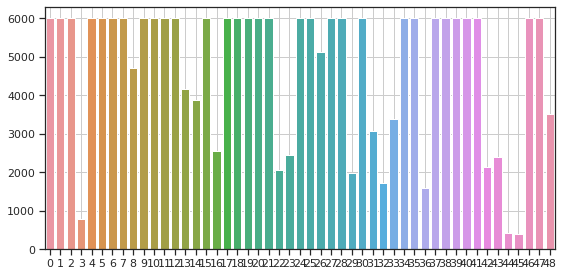

In [ ]:
labels, counts = np.unique(K49_train_label, return_counts=True)
for label, count in zip(labels, counts):
  print(f"{label}: {count}")

fig, ax = plt.subplots()
fig.set_size_inches(8, 4)
sns.barplot(x=labels, y=counts, ax=ax)
plt.grid()
plt.tight_layout()

In [ ]:
K49_train.shape

(232365, 28, 28)

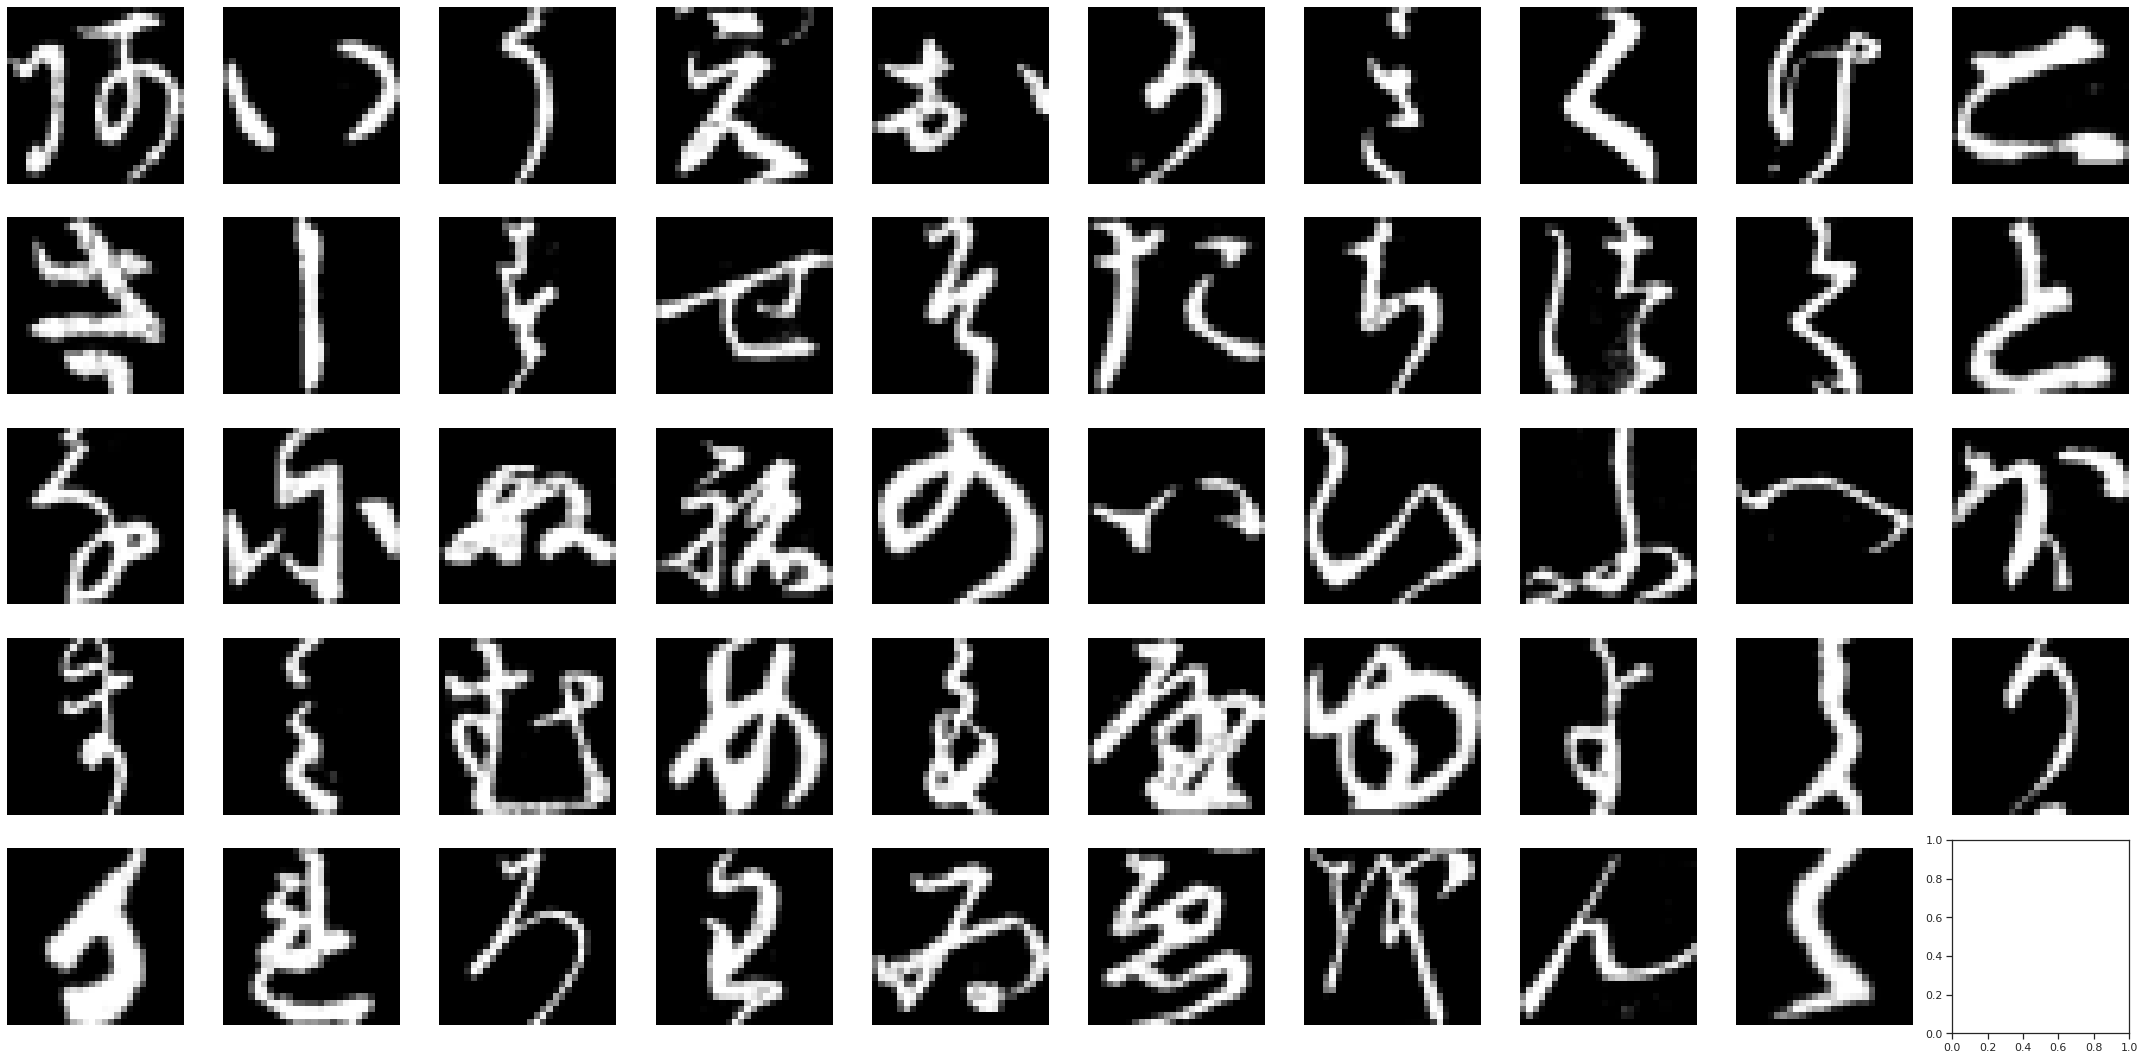

In [ ]:
fig, ax = plt.subplots(5, 10, figsize=(30, 15))
for i in range(5):
    for j in range(10):
        if (i)*10+j == 49:
            break
        images = K49_train[np.squeeze(K49_train_label == (i)*10+j)]
        subplot = ax[i, j]
        subplot.axis("off")
        subplot.imshow(images[0],cmap='gray')
plt.tight_layout()

In [ ]:
generic_compose = imageAutoAugmentImageNet = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.AutoAugment(transforms.AutoAugmentPolicy.IMAGENET),                
    transforms.RandomHorizontalFlip(0.5)])

In [ ]:
StanfordCars_train_og = datasets.StanfordCars(
    root="data",
    split='train',
    download=True,
    transform=generic_compose
)
StanfordCars_test = datasets.StanfordCars(
    root="data",
    split='test',
    download=True,
    transform=transforms.ToTensor()
)
# StanfordCars_train_og = datasets.StanfordCars(
#     root="data",
#     split='train',
#     download=True,
#     transform=generic_compose
# )
# StanfordCars_test = datasets.StanfordCars(
#     root="data",
#     split='test',
#     download=True,
#     transform=generic_compose
# )

In [ ]:
Food101_train_og = datasets.Food101(
    root="data",
    split='train',
    download=True,
    transform=generic_compose
)
Food101_test = datasets.Food101(
    root="data",
    split='test',
    download=True,
    transform=transforms.ToTensor()
)

Using downloaded and verified file: data/food-101.tar.gz
Extracting data/food-101.tar.gz to data


KeyboardInterrupt: ignored

In [ ]:
class EarlyStopping():
    def __init__(self, patience=5):
        self.patience = patience
        self.counter = 0
        self.early_stop = False
        self.lowest_val_loss = 99999999
        self.highest_val_accuracy = 0
    def __call__(self, val_acc, val_loss):
        if val_loss >= self.lowest_val_loss and val_acc <= self.highest_val_accuracy:
            self.counter +=1
        else:
            self.counter = 0
            if val_acc > self.highest_val_accuracy:
                self.highest_val_accuracy = val_acc
            if val_loss < self.lowest_val_loss:
                self.lowest_val_loss = val_loss
        if self.counter >= self.patience:  
            self.early_stop = True
        return self.early_stop
    def reset(self):
        self.counter = 0
        self.lowest_val_loss = 99999999
        self.highest_val_accuracy = 0
        self.early_stop = False

In [ ]:
mnasnet_small

In [ ]:
def train(model, loader, optimizer, NUM_EPOCHS, criterion, valloader=None,earlystopper=None,showEpoch=True,scheduler=None):
    model.train()
    for epoch in range(NUM_EPOCHS):
        t0 = time.time()
        total = 0
        correct = 0
        running_loss = 0.0
        for data in loader:
            img, label = data 
            img = img.to(device)
            label = label.to(device)
            optimizer.zero_grad()
            outputs = model(img)
            loss = criterion(outputs, label)
            loss.backward()
            optimizer.step()
            # _, predicted = torch.max(outputs.data, 1)
            correct += (outputs.argmax(-1) == label.argmax(-1)).sum().item()
            total += label.size(0)
            running_loss += loss.item()
        if scheduler is not None:
            scheduler.step()
        val_loss, val_accuracy = validate(model, criterion, valloader)
        accuracy = 100 * correct / total
        loss = running_loss / len(loader)
        print(f'- [Epoch {epoch+1}/{NUM_EPOCHS}] | Train Loss: {loss:.3f}| Train Accuracy: {accuracy} | Val Loss: {val_loss:.3f} | Val Accuracy: {val_accuracy} | Est: {time.time() - t0:.2f}s')
    # print(f'Highest Val Accuracy: {max(val_accuracy_his)}  @ epoch {epoch_his[val_accuracy_his.index(max(val_accuracy_his))]} | Lowest Val Loss: {min(val_loss_his)}  @ epoch {epoch_his[val_loss_his.index(min(val_loss_his))]}')
    # return train_loss_his, train_accuracy_his, val_loss_his, val_accuracy_his,epoch_his
 
def validate(model, criterion, loader=None):                     
    correct = 0                                               
    total = 0
    running_loss = []
    model.eval()
    for i, data in enumerate(loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        # _, predicted = torch.max(outputs.data, 1)
        correct += (outputs.argmax(-1) == labels.argmax(-1)).sum().item()
        running_loss.append(loss.item())
        total += labels.size(0)
    mean_val_accuracy = (100 * correct / total)
    mean_val_loss = sum(running_loss) / len(running_loss)
    model.train()
    return mean_val_loss, mean_val_accuracy

In [ ]:
np.expand_dims(K49_train, axis=1).shape

(232365, 1, 28, 28)

In [ ]:
np.expand_dims(K49_train, axis=1).max()

255

In [ ]:
K49_train_label.shape

In [ ]:
K49_train_label=F.one_hot(Tensor(K49_train_label).type('torch.LongTensor'),49)
K49_test_label=F.one_hot(Tensor(K49_test_label).type('torch.LongTensor'),49)

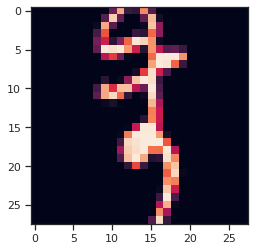

In [ ]:
plt.imshow(np.expand_dims(K49_train, axis=1)[0][0])

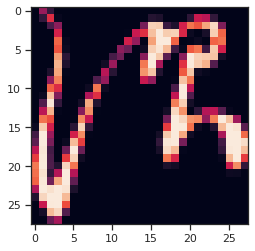

In [ ]:
plt.imshow(np.expand_dims(K49_test, axis=1)[0][0])

In [ ]:
trainloader = DataLoader(TensorDataset(Tensor(np.expand_dims(K49_train, axis=1)/255).type('torch.FloatTensor'),K49_train_label.type('torch.FloatTensor')), shuffle=True, batch_size=1024)
valloader = DataLoader(TensorDataset(Tensor(np.expand_dims(K49_test, axis=1)/255).type('torch.FloatTensor'),K49_test_label.type('torch.FloatTensor')), shuffle=False, batch_size=1024)

In [ ]:
optimizer = optim.SGD(mnasnet_small.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()

train(mnasnet_small,trainloader,optimizer,40,criterion, valloader)

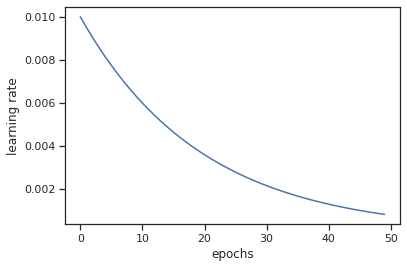

In [ ]:
epoch=50
model = torch.nn.Linear(2, 1)
opt = optim.Adam(model.parameters(),lr=0.01)
lambda1 = lambda epoch: 0.95 ** epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda=lambda1)


lrs = []
for i in range(epoch):
    opt.step()
    lrs.append(opt.param_groups[0]["lr"])
    scheduler.step()
plt.xlabel('epochs')
plt.ylabel('learning rate')
plt.plot(range(epoch),lrs)
plt.show()
del model, opt

In [ ]:
def dataset2Np(training_data,test_data):
    train_loader = DataLoader(training_data, batch_size=750)
    test_loader = DataLoader(test_data, batch_size=750)

    train_data = torch.Tensor(next(iter(train_loader))[0].numpy())
    test_data = torch.Tensor(next(iter(test_loader))[0].numpy())

    train_label = torch.Tensor(next(iter(train_loader))[1].numpy())
    test_label = torch.Tensor(next(iter(test_loader))[1].numpy())
    return train_data, train_label, test_data, test_label
# del train_loader, test_loader, training_data

In [ ]:
StanfordCars_train, StanfordCars_train_label, StanfordCars_test, StanfordCars_test_label = dataset2Np(StanfordCars_train_og,StanfordCars_test)

Full code will be uploaded to https://github.com/jonidayo